# Cross Validation Groups for VALUE datasets

10th February 2023

In [52]:
import sys
import pandas as pd
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
import cartopy.feature as crf
import cartopy.crs as ccrs

In [53]:
sys.path.append('/Users/kenzatazi/Documents/CDT/Code')
# custom modules
from load import era5, value

### Load the data

In [5]:
gauge_df = value.all_gauge_data(2000, 2005, monthly=True)

In [6]:
gauge_df

,time,station_id,tp,name,longitude,latitude,altitude
39368,2000.041667,12,0.296774,GRAZ,15.4500,47.0831,366
39369,2000.041667,13,1.170968,INNSBRUCK,11.4000,47.2667,577
39370,2000.041667,14,1.651613,SALZBURG,13.0000,47.8000,437
39371,2000.041667,15,4.877419,SONNBLICK,12.9500,47.0500,3106
39372,2000.041667,16,1.409677,WIEN,16.3500,48.2331,198
...,...,...,...,...,...,...,...
44521,2004.958333,3994,1.287097,ARKONA,13.4367,54.6817,42
44522,2004.958333,4002,2.300000,OBERSTDORF,10.2767,47.3989,806
44523,2004.958333,4004,1.200000,REGENSBURG,12.1031,49.0433,365
44524,2004.958333,5585,1.900000,SALEN,13.2600,61.1700,360


### Apply kmeans

In [11]:
cv_range_df1 = gauge_df.groupby('station_id').mean()

/var/folders/jn/8my89c2536z23fm0t2l486340000gn/T/ipykernel_40165/695430699.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  cv_range_df1 = gauge_df.groupby('station_id').mean()


In [12]:
cv_range_df1

,time,tp,longitude,latitude,altitude
station_id,,,,,
12,2002.5,2.117602,15.4500,47.0831,366.0
13,2002.5,2.501576,11.4000,47.2667,577.0
14,2002.5,3.254220,13.0000,47.8000,437.0
15,2002.5,5.730432,12.9500,47.0500,3106.0
16,2002.5,1.632771,16.3500,48.2331,198.0
...,...,...,...,...,...
3994,2002.5,1.443360,13.4367,54.6817,42.0
4002,2002.5,4.707273,10.2767,47.3989,806.0
4004,2002.5,1.901054,12.1031,49.0433,365.0


In [15]:
data = cv_range_df1[['longitude', 'latitude']].values

In [16]:
kmeans = KMeans(n_clusters=5).fit(data)

/Users/kenzatazi/miniconda3/envs/mfdgp/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [17]:
unique, counts = np.unique(kmeans.labels_, return_counts=True)
print(unique, counts)
kmeans.cluster_centers_

[0 1 2 3 4] [18 28 16 16  8]


array([[ 4.91713833, 56.92161111],
       [11.701875  , 47.26028214],
       [-1.80186313, 42.43926875],
       [23.43019375, 60.82475625],
       [23.9891125 , 42.9920375 ]])

In [18]:
cv_range_df1['fold'] = kmeans.labels_

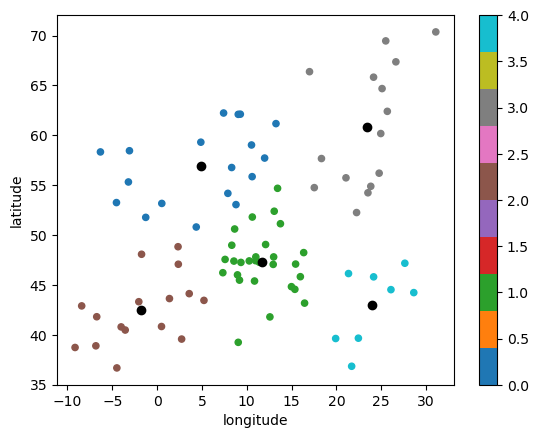

In [21]:
cv_range_df1.plot.scatter(
    x='longitude', y='latitude', c=cv_range_df1['fold'], cmap='tab10')
plt.scatter(kmeans.cluster_centers_[:, 0],
            kmeans.cluster_centers_[:, 1], c='k')


### Keep cells closest to kmean centers

In [23]:
from scipy.spatial.distance import euclidean

# Loop over all clusters and find index of closest point to the cluster center and append to closest_pt_idx list.
closest_pt_idx = []
for iclust in range(kmeans.n_clusters):
    # get all points assigned to each cluster:
    cluster_pts = cv_range_df1[cv_range_df1['fold']== iclust]
    # get all indices of points assigned to this cluster:
    cluster_pts_indices = np.where(cluster_pts['fold'] == iclust)[0]

    cluster_cen = kmeans.cluster_centers_[iclust]
    cluster_pts['e_dist'] = [euclidean(
        cluster_pts.iloc[idx].values[2:4], cluster_cen) for idx in cluster_pts_indices]
    cluster_pts.sort_values('e_dist', ignore_index=True, inplace=True)
    closest_pt_idx.append(cluster_pts[['longitude', 'latitude']].iloc[:7])


/var/folders/jn/8my89c2536z23fm0t2l486340000gn/T/ipykernel_40165/3299726650.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_pts['e_dist'] = [euclidean(
/var/folders/jn/8my89c2536z23fm0t2l486340000gn/T/ipykernel_40165/3299726650.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_pts.sort_values('e_dist', ignore_index=True, inplace=True)
/var/folders/jn/8my89c2536z23fm0t2l486340000gn/T/ipykernel_40165/3299726650.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_in

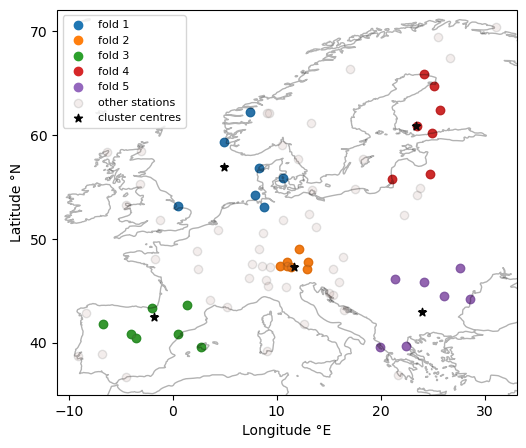

In [49]:
plt.figure(figsize=(6,5))

ax = plt.axes(projection=ccrs.PlateCarree())
ax.add_feature(crf.COASTLINE, alpha=0.3)
ax.set_xticks([-10, 0, 10, 20, 30], crs=ccrs.PlateCarree())
ax.set_yticks([30, 40, 50, 60, 70,], crs=ccrs.PlateCarree())

for i in range(len(closest_pt_idx)):
    plt.scatter(closest_pt_idx[i]['longitude'],closest_pt_idx[i]['latitude'], label='fold ' + str(i+1))


plt.scatter(cv_range_df1['longitude'], cv_range_df1['latitude'], edgecolor='k', alpha=0.1,
            zorder=8, label='other stations')    
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], 
            c='k', marker='*', label='cluster centres')

plt.xlabel('Longitude °E')
plt.ylabel('Latitude °N')

plt.legend(fontsize=8)
plt.savefig('exp1_cv.png', dpi=300)


In [51]:
# Convert to 3D array and save as .npy
cv_arr = np.array(closest_pt_idx)
print(cv_arr.shape)
np.save('exp1_cv_locs.npy', cv_arr)

(5, 7, 2)
